<a href="https://colab.research.google.com/github/rsanchezgarc/AI-ML-analytics-IE/blob/main/notebooks/5_transfer_learning/transfer_learning_finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import torchvision.datasets as datasets
import urllib.request
import zipfile
import shutil

def download_hymenoptera_data(root='./hymenoptera_data'):
    """
    Download and extract the Hymenoptera dataset.
    The dataset will be downloaded from the official source.
    """
    if os.path.exists(root):
        print("Data directory already exists. Skipping download.")
        return

    # Create directory
    os.makedirs(root, exist_ok=True)

    # URL for the dataset
    url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"

    print("Downloading Hymenoptera dataset...")
    # Download the zip file
    zip_path = os.path.join(root, "hymenoptera_data.zip")
    urllib.request.urlretrieve(url, zip_path)

    print("Extracting files...")
    # Extract the zip file
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(root)

    # Clean up - remove zip file
    os.remove(zip_path)

    # Move contents up one level (fix nested directory)
    nested_dir = os.path.join(root, 'hymenoptera_data')
    if os.path.exists(nested_dir):
        for item in os.listdir(nested_dir):
            shutil.move(os.path.join(nested_dir, item), root)
        os.rmdir(nested_dir)

    print("Dataset ready!")

def setup_data_transforms():
    """
    Set up data transformations for both training and validation.
    These transforms match ImageNet preprocessing.
    """
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(224),  # Match ImageNet input size
            transforms.RandomHorizontalFlip(),  # Data augmentation
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],  # ImageNet mean
                             [0.229, 0.224, 0.225])  # ImageNet std
        ]),
        'val': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
        ]),
    }
    return data_transforms

def load_data(data_dir):
    """
    Load the Hymenoptera dataset and create data loaders.
    This dataset contains very few images, perfect for demonstrating transfer learning.
    """
    # First, ensure the dataset is downloaded
    download_hymenoptera_data(data_dir)

    data_transforms = setup_data_transforms()

    # Load datasets
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                            data_transforms[x])
                     for x in ['train', 'val']}

    # Create data loaders
    dataloaders = {x: DataLoader(image_datasets[x], batch_size=4,
                                shuffle=True, num_workers=0)  # Set num_workers to 0 for compatibility
                  for x in ['train', 'val']}

    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
    class_names = image_datasets['train'].classes

    print(f"Dataset sizes: {dataset_sizes}")
    print(f"Classes: {class_names}")

    return dataloaders, dataset_sizes, class_names

In [ ]:
# Example: Training from Scratch
def setup_scratch_model():
    """
    Set up a ResNet50 model with randomly initialized weights.
    This demonstrates training from scratch without transfer learning.
    """
    # Load ResNet50 WITHOUT pre-trained weights
    model = models.resnet50(weights=None)  # Initialize with random weights

    # Modify the final layer for our binary classification
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 2)  # 2 classes (ants and bees)

    # Create optimizer with larger learning rate since we're training from scratch
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    return model, optimizer

# Transfer Learning (Feature Extraction)
def setup_transfer_learning_model():
    """
    Set up a model for transfer learning where we only train the final layer.
    This is useful when we have a very small dataset.
    """
    # Load pre-trained ResNet50
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)  # Updated syntax for loading pretrained model

    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False

    # Replace the final layer
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 2)  # 2 classes (ants and bees)
    return model

#There is another simple way of removing the last 2 layers if you want to use a random forest
# new_model = nn.Sequential(*list(model.children())[:-2])
# Now, if you execute new_model(imag).flatten(start_dim=1), you will get a tensor of shape BxF
# This vector can be used to train another classifier like a random forest

# Example: Fine-tuning
def setup_fine_tuning_model():
    """
    Set up a model for fine-tuning where we train all layers but with different
    learning rates for different parts of the network.
    """
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

    # Modify the final layer
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 2)

    # Create parameter groups with different learning rates
    # The final layer gets a higher learning rate
    params_to_update = []
    params_to_update_final = []

    for name, param in model.named_parameters():
        if "fc" in name:
            params_to_update_final.append(param)
        else:
            params_to_update.append(param)

    optimizer = optim.SGD([
        {'params': params_to_update, 'lr': 0.001},
        {'params': params_to_update_final, 'lr': 0.01}
    ], momentum=0.9)

    return model, optimizer

def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, num_epochs=10):
    """
    Train the model and return training history.
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model = model.to(device)

    history = {'train_loss': [], 'val_loss': [],
               'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass + optimize only in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # Store history
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.cpu())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.cpu())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return model, history

def plot_training_history(history):
    """
    Plot training and validation loss/accuracy curves.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot loss
    ax1.plot(history['train_loss'], label='train')
    ax1.plot(history['val_loss'], label='val')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot accuracy
    ax2.plot(history['train_acc'], label='train')
    ax2.plot(history['val_acc'], label='val')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.show()
def print_parameter_count(model, model_name):
    """
    Print the number of trainable parameters in the model.
    """
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"\n{model_name} Parameter Count:")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Total parameters: {total_params:,}")
    print(f"Percentage trainable: {100 * trainable_params / total_params:.2f}%")

def compare_training_histories(scratch_history, transfer_history, fine_tune_history):
    """
    Plot and compare training histories for all three approaches.
    """
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Plot training loss
    ax1.plot(scratch_history['train_loss'], label='from scratch')
    ax1.plot(transfer_history['train_loss'], label='transfer learning')
    ax1.plot(fine_tune_history['train_loss'], label='fine-tuning')
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot validation loss
    ax2.plot(scratch_history['val_loss'], label='from scratch')
    ax2.plot(transfer_history['val_loss'], label='transfer learning')
    ax2.plot(fine_tune_history['val_loss'], label='fine-tuning')
    ax2.set_title('Validation Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    # Plot training accuracy
    ax3.plot(scratch_history['train_acc'], label='from scratch')
    ax3.plot(transfer_history['train_acc'], label='transfer learning')
    ax3.plot(fine_tune_history['train_acc'], label='fine-tuning')
    ax3.set_title('Training Accuracy')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Accuracy')
    ax3.legend()

    # Plot validation accuracy
    ax4.plot(scratch_history['val_acc'], label='from scratch')
    ax4.plot(transfer_history['val_acc'], label='transfer learning')
    ax4.plot(fine_tune_history['val_acc'], label='fine-tuning')
    ax4.set_title('Validation Accuracy')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Accuracy')
    ax4.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
# Set up data
data_dir = 'hymenoptera_data'
dataloaders, dataset_sizes, class_names = load_data(data_dir)
criterion = nn.CrossEntropyLoss()


Extracting files...
Dataset ready!
Dataset sizes: {'train': 244, 'val': 153}
Classes: ['ants', 'bees']



Running Training from Scratch Example...

Training from Scratch Parameter Count:
Trainable parameters: 23,512,130
Total parameters: 23,512,130
Percentage trainable: 100.00%
Using device: cuda:0
Epoch 0/24
----------
train Loss: 5.4042 Acc: 0.5082
val Loss: 16.9606 Acc: 0.4771
Epoch 1/24
----------
train Loss: 2.4382 Acc: 0.5041
val Loss: 0.9168 Acc: 0.4510
Epoch 2/24
----------
train Loss: 0.8626 Acc: 0.4795
val Loss: 0.7830 Acc: 0.4575
Epoch 3/24
----------
train Loss: 0.9733 Acc: 0.5246
val Loss: 7.9961 Acc: 0.5033
Epoch 4/24
----------
train Loss: 1.0714 Acc: 0.5205
val Loss: 16.4325 Acc: 0.5490
Epoch 5/24
----------
train Loss: 0.8364 Acc: 0.5000
val Loss: 1.1586 Acc: 0.5098
Epoch 6/24
----------
train Loss: 0.9534 Acc: 0.4918
val Loss: 13.4737 Acc: 0.4575
Epoch 7/24
----------
train Loss: 1.0081 Acc: 0.5369
val Loss: 1.6719 Acc: 0.5882
Epoch 8/24
----------
train Loss: 0.8526 Acc: 0.4754
val Loss: 1.4491 Acc: 0.6144
Epoch 9/24
----------
train Loss: 0.7973 Acc: 0.5369
val Loss: 3

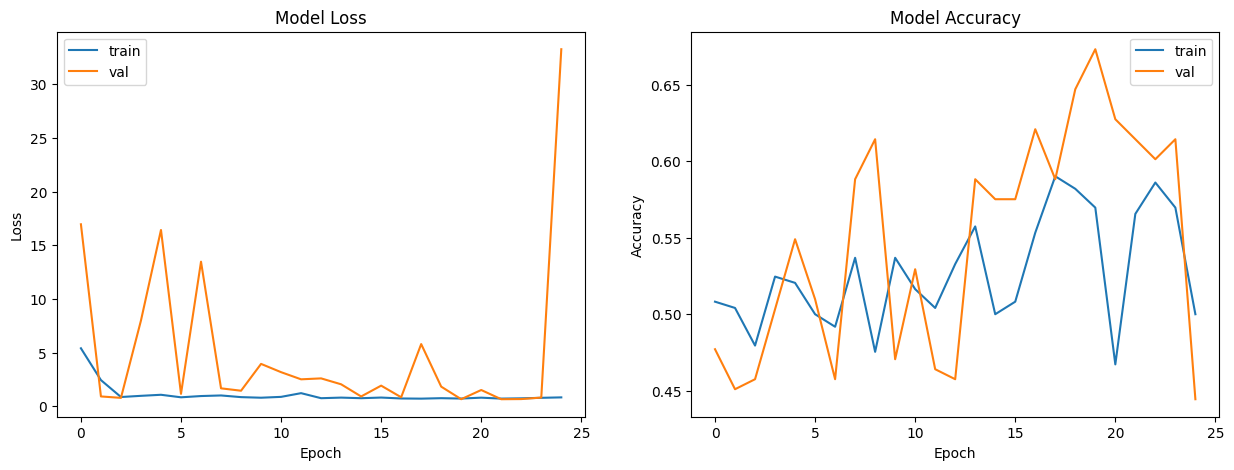

In [ ]:
# Example 1: Training from Scratch
print("\nRunning Training from Scratch Example...")
scratch_model, scratch_optimizer = setup_scratch_model()
print_parameter_count(scratch_model, "Training from Scratch")

scratch_model, scratch_history = train_model(
    scratch_model, dataloaders, dataset_sizes, criterion, scratch_optimizer, num_epochs=25)

plot_training_history(scratch_history)




Running Transfer Learning Example...


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 183MB/s]



Transfer Learning Parameter Count:
Trainable parameters: 4,098
Total parameters: 23,512,130
Percentage trainable: 0.02%
Using device: cuda:0
Epoch 0/24
----------
train Loss: 0.6425 Acc: 0.6639
val Loss: 0.4783 Acc: 0.9739
Epoch 1/24
----------
train Loss: 0.4966 Acc: 0.8607
val Loss: 0.3338 Acc: 0.9608
Epoch 2/24
----------
train Loss: 0.4321 Acc: 0.8566
val Loss: 0.2711 Acc: 0.9804
Epoch 3/24
----------
train Loss: 0.3932 Acc: 0.8566
val Loss: 0.2307 Acc: 0.9804
Epoch 4/24
----------
train Loss: 0.3757 Acc: 0.8730
val Loss: 0.2261 Acc: 0.9804
Epoch 5/24
----------
train Loss: 0.3324 Acc: 0.9016
val Loss: 0.1950 Acc: 0.9673
Epoch 6/24
----------
train Loss: 0.3171 Acc: 0.8770
val Loss: 0.1879 Acc: 0.9673
Epoch 7/24
----------
train Loss: 0.3188 Acc: 0.8730
val Loss: 0.1706 Acc: 0.9804
Epoch 8/24
----------
train Loss: 0.3368 Acc: 0.8566
val Loss: 0.1521 Acc: 0.9869
Epoch 9/24
----------
train Loss: 0.3059 Acc: 0.8934
val Loss: 0.1545 Acc: 0.9869
Epoch 10/24
----------
train Loss: 0.3

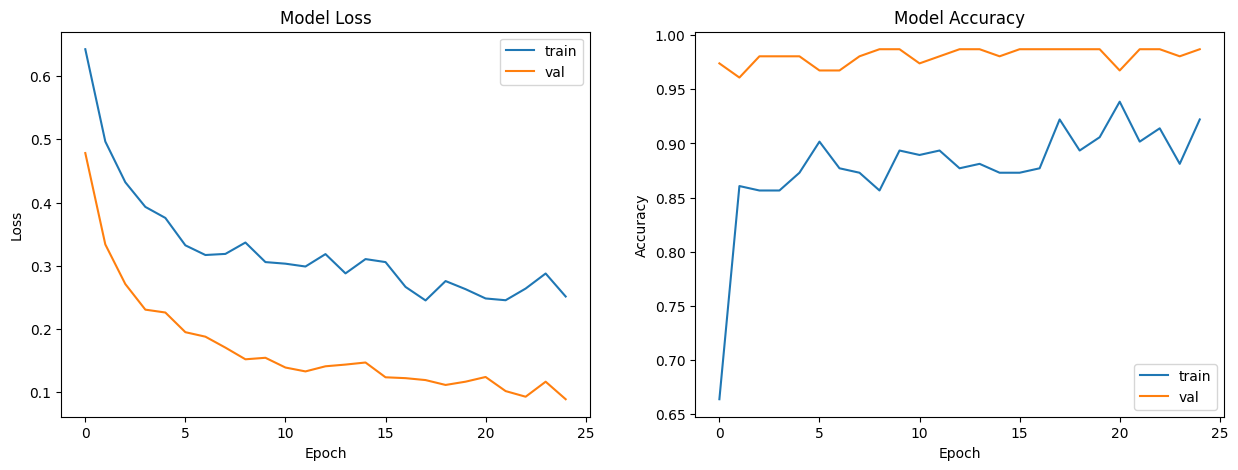

In [ ]:
# Example 2: Transfer Learning
print("\nRunning Transfer Learning Example...")
transfer_model = setup_transfer_learning_model()
print_parameter_count(transfer_model, "Transfer Learning")
# Only optimize the final layer parameters
optimizer = optim.SGD(transfer_model.fc.parameters(), lr=0.001, momentum=0.9)

transfer_model, transfer_history = train_model(
    transfer_model, dataloaders, dataset_sizes, criterion, optimizer, num_epochs=25)

plot_training_history(transfer_history)



Running Fine-tuning Example...

Fine-tuning Parameter Count:
Trainable parameters: 23,512,130
Total parameters: 23,512,130
Percentage trainable: 100.00%
Using device: cuda:0
Epoch 0/24
----------
train Loss: 0.4583 Acc: 0.7746
val Loss: 0.1115 Acc: 0.9673
Epoch 1/24
----------
train Loss: 0.3491 Acc: 0.8402
val Loss: 0.1282 Acc: 0.9739
Epoch 2/24
----------
train Loss: 0.3614 Acc: 0.8443
val Loss: 0.1134 Acc: 0.9673
Epoch 3/24
----------
train Loss: 0.2002 Acc: 0.9180
val Loss: 0.0999 Acc: 0.9542
Epoch 4/24
----------
train Loss: 0.2174 Acc: 0.9057
val Loss: 0.0998 Acc: 0.9739
Epoch 5/24
----------
train Loss: 0.2185 Acc: 0.9221
val Loss: 0.1101 Acc: 0.9542
Epoch 6/24
----------
train Loss: 0.1562 Acc: 0.9508
val Loss: 0.0965 Acc: 0.9542
Epoch 7/24
----------
train Loss: 0.1588 Acc: 0.9303
val Loss: 0.1051 Acc: 0.9412
Epoch 8/24
----------
train Loss: 0.1315 Acc: 0.9426
val Loss: 0.1032 Acc: 0.9608
Epoch 9/24
----------
train Loss: 0.2461 Acc: 0.9180
val Loss: 0.1321 Acc: 0.9608
Epoch

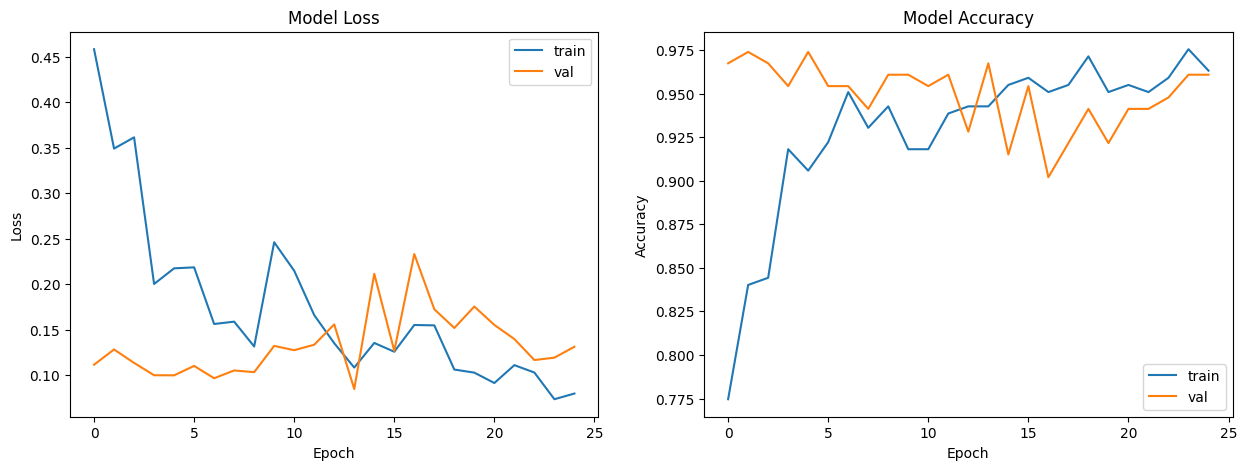

In [ ]:
# Example 3: Fine-tuning
print("\nRunning Fine-tuning Example...")
fine_tune_model, fine_tune_optimizer = setup_fine_tuning_model()
print_parameter_count(fine_tune_model, "Fine-tuning")

fine_tune_model, fine_tune_history = train_model(
    fine_tune_model, dataloaders, dataset_sizes, criterion, fine_tune_optimizer, num_epochs=25)

plot_training_history(fine_tune_history)


Comparing all three approaches...


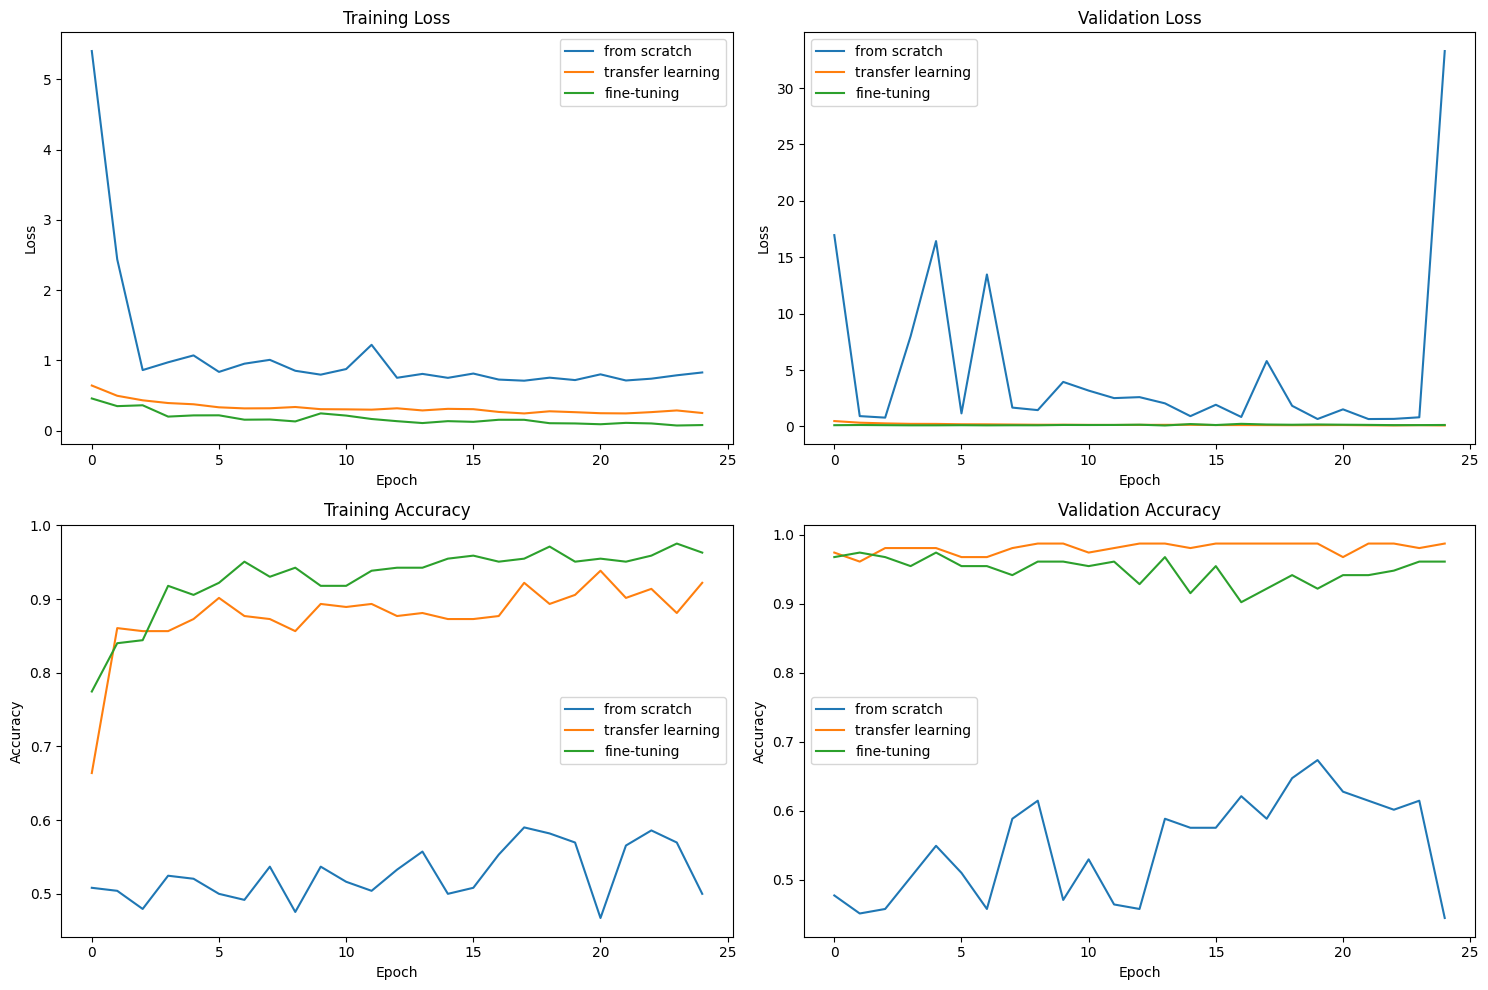


Final Validation Accuracies:
Training from Scratch: 0.4444
Transfer Learning: 0.9869
Fine-tuning: 0.9608


In [ ]:
# Compare all three approaches
print("\nComparing all three approaches...")
compare_training_histories(scratch_history, transfer_history, fine_tune_history)

# Print final validation accuracies
print("\nFinal Validation Accuracies:")
print(f"Training from Scratch: {scratch_history['val_acc'][-1]:.4f}")
print(f"Transfer Learning: {transfer_history['val_acc'][-1]:.4f}")
print(f"Fine-tuning: {fine_tune_history['val_acc'][-1]:.4f}")


Generating prediction visualizations...


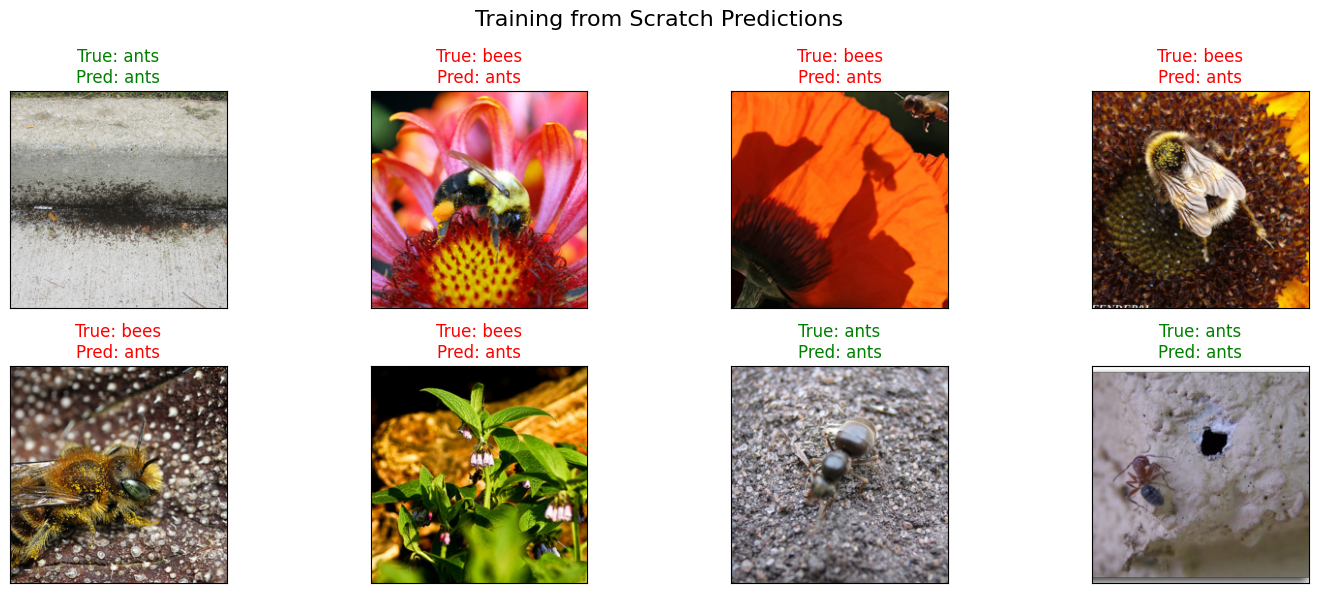

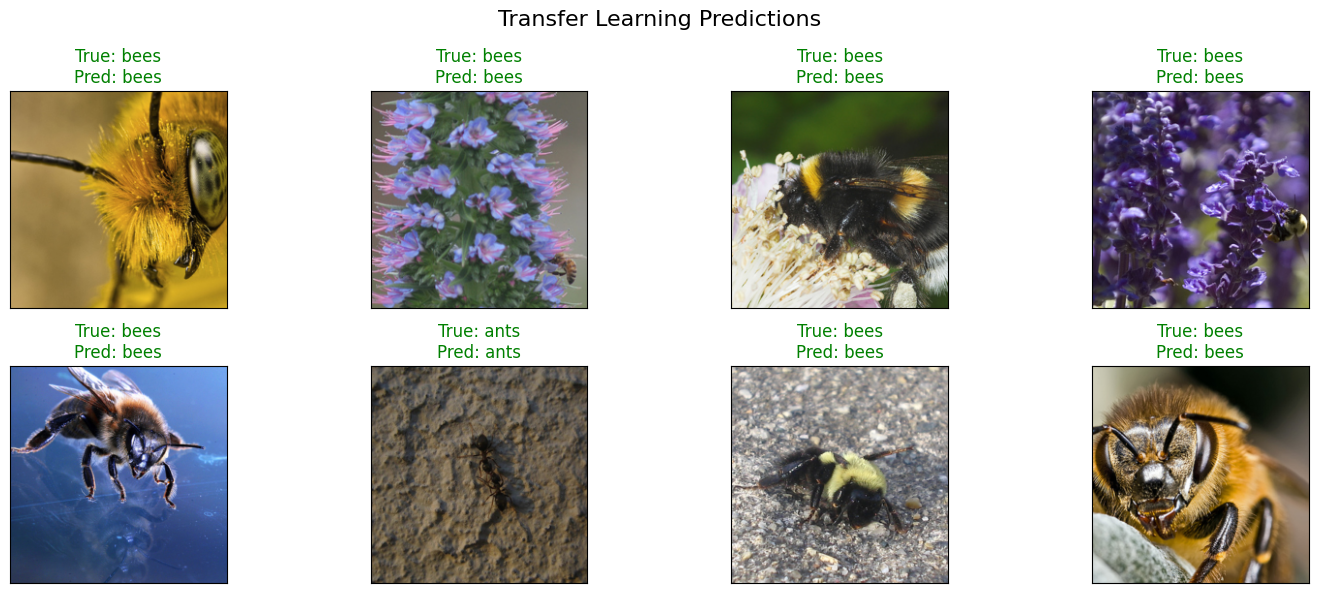

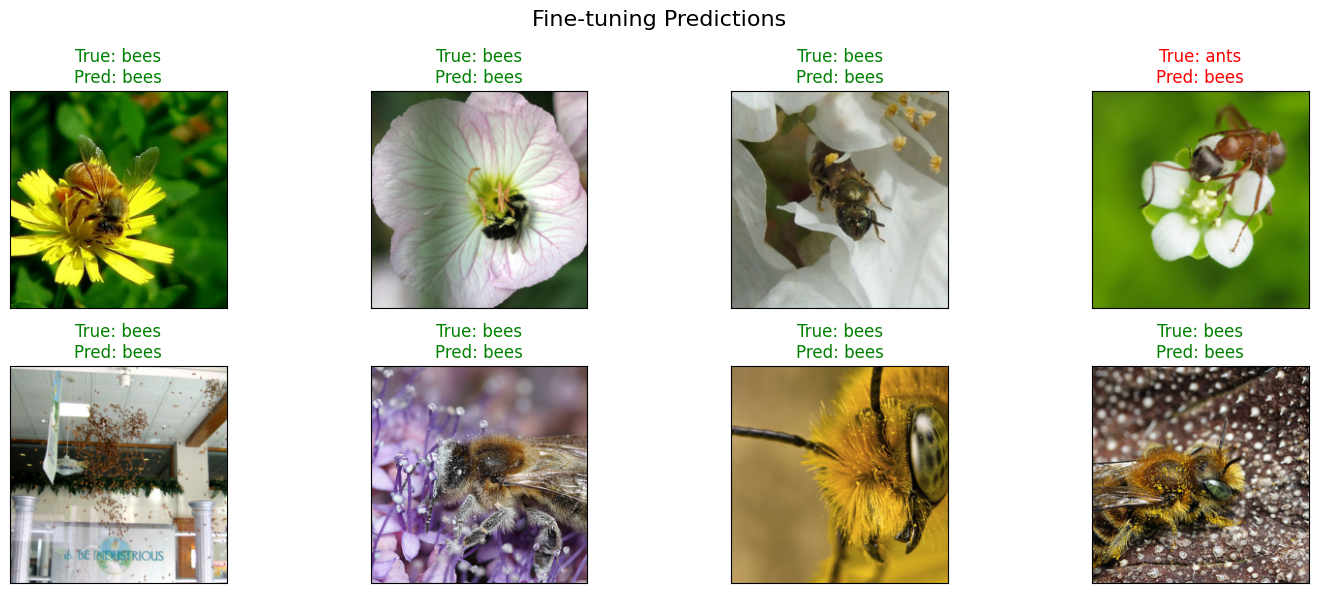


Saving models...


In [ ]:
def denormalize_image(tensor):
    """
    Convert normalized image tensor back to displayable image.
    Reverses the ImageNet normalization.
    """
    # Move mean and std to the same device as the input tensor
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(tensor.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(tensor.device)

    # Denormalize
    tensor = tensor * std + mean

    # Clamp values to valid range
    tensor = torch.clamp(tensor, 0, 1)

    return tensor

def get_predictions(model, dataloader, num_images=8):
    """
    Get predictions for a few sample images.
    Returns images, true labels, and predictions.
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.eval()

    all_images = []
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in dataloader:
            if len(all_images) >= num_images:
                break

            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            # Process each image
            for img, label, pred in zip(images, labels, preds):
                # Denormalize and move to CPU for plotting
                denorm_img = denormalize_image(img)
                all_images.append(denorm_img.cpu())
                all_labels.append(label.cpu().item())
                all_preds.append(pred.cpu().item())

            if len(all_images) >= num_images:
                break

    return all_images[:num_images], all_labels[:num_images], all_preds[:num_images]

def plot_predictions(images, labels, predictions, class_names, model_name):
    """
    Plot images with their true labels and predictions.
    """
    n = len(images)
    fig, axes = plt.subplots(2, n//2, figsize=(15, 6))
    axes = axes.ravel()

    for idx, (img, label, pred) in enumerate(zip(images, labels, predictions)):
        # Convert tensor to numpy array and transpose to correct format
        img_np = img.cpu().numpy().transpose(1, 2, 0)

        # Plot image
        axes[idx].imshow(img_np)

        # Set title with true label and prediction
        color = 'green' if label == pred else 'red'
        axes[idx].set_title(f'True: {class_names[label]}\nPred: {class_names[pred]}',
                          color=color)

        # Remove axis ticks
        axes[idx].set_xticks([])
        axes[idx].set_yticks([])

    plt.suptitle(f'{model_name} Predictions', size=16)
    plt.tight_layout()
    plt.show()

def visualize_model_predictions(scratch_model, transfer_model, fine_tune_model,
                              dataloaders, class_names):
    """
    Visualize and compare predictions from all three models.
    """
    # Get predictions from validation set
    val_loader = dataloaders['val']

    print("\nGenerating prediction visualizations...")

    # Get predictions from each model
    scratch_images, scratch_labels, scratch_preds = get_predictions(scratch_model, val_loader)
    transfer_images, transfer_labels, transfer_preds = get_predictions(transfer_model, val_loader)
    fine_tune_images, fine_tune_labels, fine_tune_preds = get_predictions(fine_tune_model, val_loader)

    # Plot predictions for each model
    plot_predictions(scratch_images, scratch_labels, scratch_preds,
                    class_names, "Training from Scratch")
    plot_predictions(transfer_images, transfer_labels, transfer_preds,
                    class_names, "Transfer Learning")
    plot_predictions(fine_tune_images, fine_tune_labels, fine_tune_preds,
                    class_names, "Fine-tuning")



visualize_model_predictions(scratch_model, transfer_model, fine_tune_model,
                          dataloaders, class_names)

# Save models if needed
print("\nSaving models...")
torch.save(scratch_model.state_dict(), 'scratch_model.pth')
torch.save(transfer_model.state_dict(), 'transfer_model.pth')
torch.save(fine_tune_model.state_dict(), 'fine_tune_model.pth')